# TO DO:

I) Belleza del código.

    1) Convertir listas en numpy array.
    
II) Preprocesamiento, ML, yerbas...

    1) (http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers]Probar "robust_scale and RobustScaler" en vez de normalization de los datos
    2) Probar Grid_SearchCV en vez del "for"
    
III) Probar más hiperparametros

In [183]:
# Python 2 
from __future__ import division

# Preprocessing
from sklearn import preprocessing

# Dataframe
import pandas as pd
import numpy as np

# Time measurement
import datetime

# Visu
import matplotlib.pyplot as plt

# The Hashing Trick
from sklearn.feature_extraction import FeatureHasher

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD

# ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor

# Scoring
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Training Data Load

In [184]:
stations = pd.read_csv('data/station.csv')

trips = pd.read_csv('data/trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [185]:
trips.columns

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'zip_code'],
      dtype='object')

In [186]:
trips['date'] = pd.to_datetime(trips.start_date.dt.date)

In [187]:
original_number_of_trips = trips['duration'].shape[0]

trip_length = 60*60*12     # seconds in 12 hours
trips_larger_than_12_hour = trips[trips['duration'] > trip_length]['duration'].sum()
trips_shorter_than_12_hour = trips[trips['duration'] < trip_length]['duration'].sum()
ratio = trips_larger_than_12_hour/trips_shorter_than_12_hour
print (trips_larger_than_12_hour,"/",trips_shorter_than_12_hour,'=',ratio)

118116828 / 494218194 = 0.23899732837435766


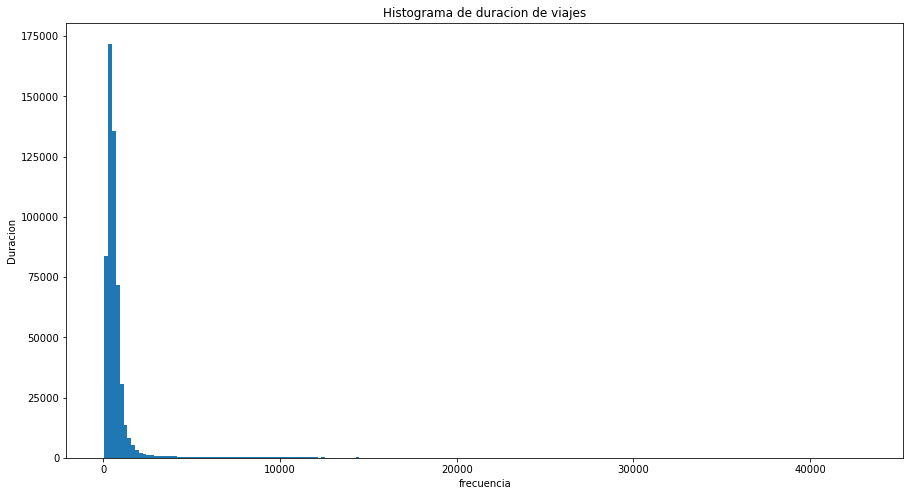

In [188]:
plt.figure(figsize=(15,8))
plt.title("Histograma de duracion de viajes")
plt.xlabel('frecuencia')
plt.ylabel('Duracion')
plt.hist(x=trips[trips['duration'] < trip_length]['duration'],bins=200)
plt.show()

In [189]:
trips = trips[trips['duration'] < trip_length]
print ("Total de viajes luego de remover outliers: " + str(trips.shape[0]))

Total de viajes luego de remover outliers: 548986


In [190]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)

In [191]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')

In [192]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [193]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [194]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors='coerse')
weather.precipitation_inches.fillna(0,inplace=True)

In [195]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [196]:
# transformar cada date en segundos desde 29/04/1994
data.start_date = data.start_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

data.end_date = data.end_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

In [197]:
data.drop(labels=['id','start_station_name','end_station_name','date','zip_code','bike_id'], axis=1, inplace=True)
data.columns

Index(['duration', 'start_date', 'start_station_id', 'end_date',
       'end_station_id', 'subscription_type', 'city_zip_code',
       'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees'],
      dtype='object')

#  Test Data Load

In [198]:
trip_test = pd.read_csv('data/trip_test.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True)
trip_test.columns

Index(['id', 'start_date', 'start_station_name', 'start_station_id',
       'end_date', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'zip_code'],
      dtype='object')

In [199]:
# se agrega el zip_code de la ciudad de la start station a cada viaje del set de test
trip_test = pd.merge(trip_test, stations_to_join, on='start_station_id', how='left')

In [200]:
trip_test['date'] = pd.to_datetime(trip_test.start_date.dt.date)

trip_test = pd.merge(trip_test, weather, on=['date','city_zip_code'], how='inner')

In [201]:
# transformar cada date en segundos desde 29/04/1994
trip_test.start_date = trip_test.start_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

In [202]:
trip_test.drop(labels=['id','start_station_name','end_station_name','date','zip_code','bike_id'], axis=1, inplace=True)

In [203]:
trip_test.columns

Index(['start_date', 'start_station_id', 'end_date', 'end_station_id',
       'subscription_type', 'city_zip_code', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'events', 'wind_dir_degrees'],
      dtype='object')

# The Hashing Trick

In [204]:
temp = []
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']

for row in data.loc[:,column_labels].iterrows():
    index, value = row
    for i in range(len(value)):
        value[i] = str(value[i])
    temp.append(value.tolist())

In [205]:
h = FeatureHasher(n_features=10, input_type='string')
f = h.transform(raw_X=temp)

In [206]:
print("Porcentaje de dispersidad: " + str((f.nnz/(f.shape[0] * f.shape[1]))*100) + " %")

Porcentaje de dispersidad: 41.19389201181815 %


In [207]:
data = pd.concat([data,pd.DataFrame(f.todense())],axis=1)
data.drop(labels=column_labels,axis=1,inplace=True)

In [208]:
# Verificamos que sean todos numericos
data.dtypes

duration                            int64
start_date                          int64
end_date                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
wind_dir_degrees                  

In [209]:
data = data.dropna(how='any').reset_index(drop=True)

In [210]:
print ("Cantidad de muestras en train set: "+str(data.shape[0]))

Cantidad de muestras en train set: 532389


In [211]:
# Separamos y de x
target_values = data['duration']
data.drop(labels='duration', axis=1, inplace=True)

# Data Standarization

[scaler normaliza test y train set de la misma manera.](http://scikit-learn.org/stable/modules/preprocessing.html)

In [212]:
scaler = preprocessing.StandardScaler().fit(data)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [227]:
data = scaler.transform(data) # devuelve una matriz

# Data Normalization

In [214]:
#data = (data - data.mean()) / (data.max() - data.min())

# Dimension Reduction

## SVD

In [218]:
u,s,v = np.linalg.svd(data,full_matrices=0)

## Energía de la matriz

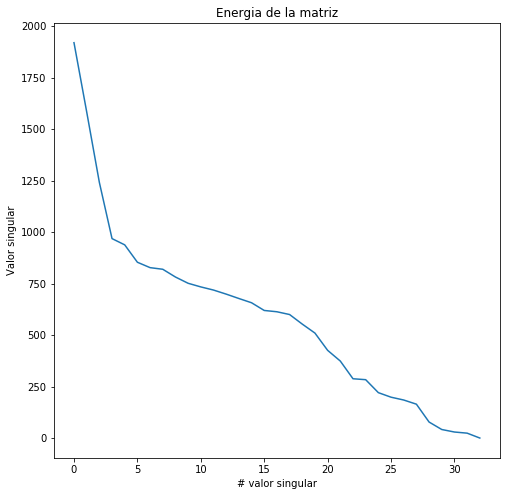

In [219]:
plt.figure(figsize=(8,8))
plt.xlabel("# valor singular")
plt.ylabel('Valor singular')
plt.title("Energia de la matriz")
plt.plot(s)
plt.show()

Vemos un codo en x = 5

# Aproximation error

In [220]:
dim = 5
closeness = np.isclose(np.dot(np.dot(u[:,0:dim],np.diag(s)[0:dim,0:dim]),v[0:dim,:]),data,atol=0.1,rtol=0.1)
print (str((closeness.sum()/(closeness.shape[0]*closeness.shape[1])*100).round(2)) + " %")

30.07 %


# Truncated SVD

[...it can work with scipy.sparse matrices efficiently.](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [221]:
svd = TruncatedSVD(n_components=7, n_iter=7, random_state=42)
truncated_svd_aprox = svd.fit_transform(data)

# KNN 

In [222]:
reduced_data = truncated_svd_aprox

In [225]:
k_neighbors = np.array(range(10,1001,10))
metrics = ['euclidean', 'manhattan']
KNN_cv_scores = np.zeros(shape=(len(k_neighbors),len(metrics)))

for i,k in enumerate(k_neighbors):
    for j,metric in enumerate(metrics):
        
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric, weights = 'distance',n_jobs=-1)
        scores = cross_val_score(knn, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')
        KNN_cv_scores[i][j] = scores.mean()

In [226]:
KNN_cv_scores.round(2)

array([[-4502797.34, -4496097.56],
       [-4472026.31, -4471309.29]])

In [ ]:
KNN_cv_scores = np.array([[-6134361.15, -6079000.66],
					  [-5351858.19, -5360234.74],
					  [-5096953.65, -5095805.17],
					  [-4982807.73, -4969350.65],
					  [-4907901.23, -4890164.21],
					  [-4852908.1 , -4834866.28],
					  [-4817307.43, -4797754.1 ],
					  [-4790579.12, -4769114.32],
					  [-4767948.63, -4745718.41],
					  [-4751342.63, -4727356.28],
					  [-4739709.84, -4711076.88],
					  [-4726830.06, -4696665.8 ],
					  [-4715715.18, -4687716.97],
					  [-4706229.36, -4678451.76],
					  [-4697689.8 , -4670741.08],
					  [-4691308.05, -4665357.65],
					  [-4684562.35, -4659308.18],
					  [-4677509.1 , -4653394.41],
					  [-4672237.78, -4648805.1 ],
					  [-4667755.94, -4644264.32],
					  [-4662907.25, -4640719.22],
					  [-4658321.77, -4637249.78],
					  [-4654066.51, -4632933.27],
					  [-4650221.86, -4629486.34],
					  [-4646538.86, -4627016.1 ],
					  [-4642953.85, -4623886.01],
					  [-4639515.33, -4621242.79],
					  [-4636040.7 , -4618465.53],
					  [-4632803.81, -4615791.91],
					  [-4629935.04, -4613384.22],
					  [-4626602.03, -4611437.69],
					  [-4623721.83, -4608700.33],
					  [-4620566.86, -4606371.71],
					  [-4617386.36, -4604447.74],
					  [-4614419.37, -4603139.35],
					  [-4611734.2 , -4601562.83],
					  [-4609026.51, -4600178.79],
					  [-4607345.74, -4598160.78],
					  [-4605116.73, -4596688.19],
					  [-4603376.65, -4595194.93],
					  [-4601587.53, -4593121.06],
					  [-4600001.43, -4591552.04],
					  [-4598164.87, -4589910.62],
					  [-4596167.67, -4588453.26],
					  [-4594644.11, -4587628.87],
					  [-4593058.82, -4586432.97],
					  [-4591440.79, -4585359.34],
					  [-4590444.87, -4584486.15],
					  [-4588931.37, -4583458.19],
					  [-4587514.33, -4582651.52],
					  [-4585932.58, -4581528.13],
					  [-4584639.75, -4580836.93],
					  [-4583219.7 , -4579824.95],
					  [-4582349.66, -4579051.76],
					  [-4581703.28, -4578455.81],
					  [-4580664.6 , -4577890.98],
					  [-4579859.66, -4577140.71],
					  [-4578952.79, -4576545.1 ],
					  [-4578190.6 , -4576011.88],
					  [-4577508.68, -4575313.46],
					  [-4576812.1 , -4574810.81],
					  [-4576117.07, -4574246.79],
					  [-4575456.42, -4573528.77],
					  [-4575079.77, -4572995.22],
					  [-4574456.42, -4572555.19],
					  [-4573733.31, -4572173.41],
					  [-4572835.86, -4571679.54],
					  [-4571944.24, -4571347.05],
					  [-4571243.67, -4570827.76],
					  [-4570673.91, -4570314.32],
					  [-4570125.56, -4569726.02],
					  [-4569402.35, -4569275.26],
					  [-4568853.66, -4568817.24],
					  [-4568299.57, -4568358.15],
					  [-4567749.82, -4567980.21],
					  [-4567306.32, -4567479.81],
					  [-4566973.99, -4567107.05],
					  [-4566390.23, -4566979.09],
					  [-4566209.39, -4566688.21],
					  [-4565677.62, -4565677.62]])

KNN_cv_scores.max()

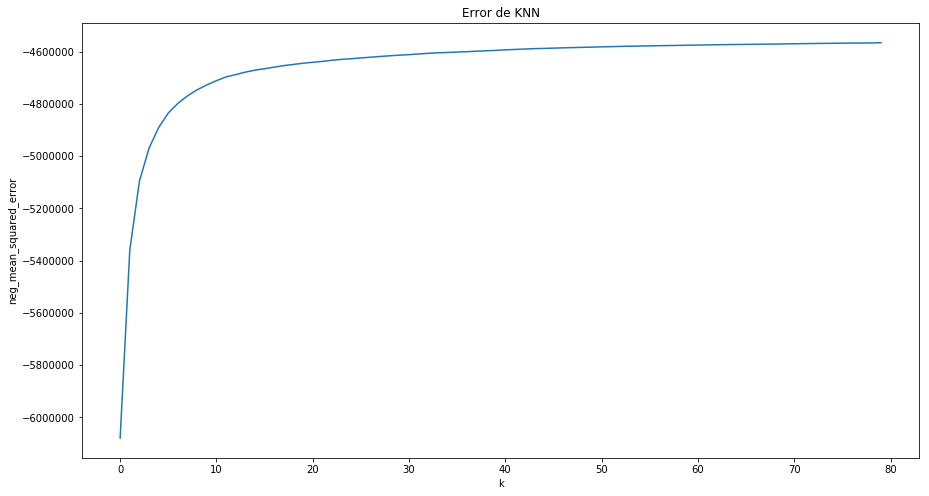

In [77]:
plt.figure(figsize=(15,8))
plt.plot(KNN_cv_scores[:,1])
plt.title("Error de KNN")
plt.xlabel("k")
plt.ylabel("neg_mean_squared_error")
plt.show()

In [76]:
# print (np.array(KNN_cv_scores).round(2)

# Estos prints están mal

print ("Best MSE: " + str(np.array(KNN_cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(KNN_cv_scores).round(2).argmax(axis=0)))
print ("Best k: " + str(k_neighbors[KNN_cv_scores.round(2).argmax(axis=1)[0]]) )
print ("Best metric: " + str(metrics[KNN_cv_scores.round(2).argmax(axis=1)[1]] ) )

Best MSE: -4565677.62
Index of best MSE: [79 79]
Best k: 20
Best metric: euclidean


# Decision Tree Regressor

In [ ]:
possible_depth = np.array(range(10,1001,10))

In [ ]:
cv_scores = []

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    scores = cross_val_score(regr_1, data, target_values, cv=10, scoring='neg_mean_squared_error')
    DTR_cv_scores.append(scores.mean())

In [ ]:
print ("Best MSE: " + str(np.array(cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(cv_scores).round(2).argmax()))
print ("Best depth: " + str(possible_depth[np.array(cv_scores).round(2).argmax()]))

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

# Random Forest Regressor

In [ ]:
regr_1 = RandomForestRegressor(n_estimators=5, criterion='mse')
scores = cross_val_score(regr_1, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')

In [ ]:
scores.mean()